In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.io as io

plt.rc("font", family=["Helvetica", "Arial"]) #skifter skrifttype
plt.rc("axes", labelsize=18)   #skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=16, direction="out")  #skriftstørrelse af ticks og viser ticks øverst
plt.rc("ytick", labelsize=16, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=16)

In [5]:
entries_list_pT = os.listdir(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\Glas til luft\p\Datafiler\transmitteret")
entries_list_pR = os.listdir(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\Glas til luft\p\Datafiler\reflekteret")

d = io.loadmat(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\baggrund måling.mat")
d_offset = d.get("A")
d_offset = np.reshape(d_offset, (len(d_offset)))

# Konstant funktion
def func(x, a):
    return a

# Fit af kontakt funktion til gennemsnit
t = np.linspace(0, 50, len(d_offset))
mean_Voff, pcovoff = curve_fit(func, t, d_offset, absolute_sigma=True)
usOff = np.sqrt(np.diag(pcovoff))

# Henter data fra 90 grader 
d = io.loadmat(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\Glas til luft\p - 90 grader med krystal.mat")
d90 = d.get("A")
d90 = np.reshape(d90, (len(d90)))

# Fit af kontakt funktion til 90 grader
t = np.linspace(0, 50, len(d90))
mean_V90, pcov90 = curve_fit(func, t, d90, absolute_sigma=True)
us90 = np.sqrt(np.diag(pcov90))
mean_V90 = mean_V90 - mean_Voff



In [6]:
# Funktion som henter intensiteterne 

def get_ts_Vs(t, entries):
    if t == "T":
        rempart = "t("
        file_dest = "transmitteret"
    else:
        rempart = "r("
        file_dest = "reflekteret"
        
    ts = np.zeros((len(entries), 2))
    Vs = np.zeros((len(entries),2))
    for i, file in enumerate(entries):
        name = file.replace(rempart, "")
        name = name.replace(".mat", "")
        name = name.replace(")", "")
        indx = name.find(",")
        ts12 = float(name[0:indx])*np.pi/180, float(name[indx + 1:len(name)])*np.pi/180
        ts[i] = ts12
        
    for i, file in enumerate(entries):
        dat = io.loadmat(f"C:/Users/Karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/Glas til luft/p/Datafiler/{file_dest}/{file}")
        V = dat.get("A")
        V = np.reshape(V, (len(V)))
        xs = np.linspace(0, 50, len(V))
        fitted, pcov = curve_fit(func, xs, V, absolute_sigma=True)
        perr1 = np.sqrt(np.diag(pcov))
        Vs[i][0] = fitted - mean_Voff
        Vs[i][1] = perr1
        
    return Vs, ts

In [7]:
# Henter thetaer og intensiteter

mean_VsT, ts_trans = get_ts_Vs("T", entries_list_pT)
mean_VsR, ts_ref = get_ts_Vs("R", entries_list_pR)


In [8]:
# Finder Rp og Tp

Ts = mean_VsT/mean_V90
Rs = mean_VsR/mean_V90


In [9]:
uncer = 0.5 # DEGREES
sigma_radian = np.pi/180 * uncer
print(sigma_radian)


0.008726646259971648


[0.17453293 0.26179939 0.29670597 0.34906585 0.38397244 0.43633231
 0.4712389  0.50614548 0.54105207 0.57595865 0.61086524 0.64577182
 0.68067841 0.71558499]


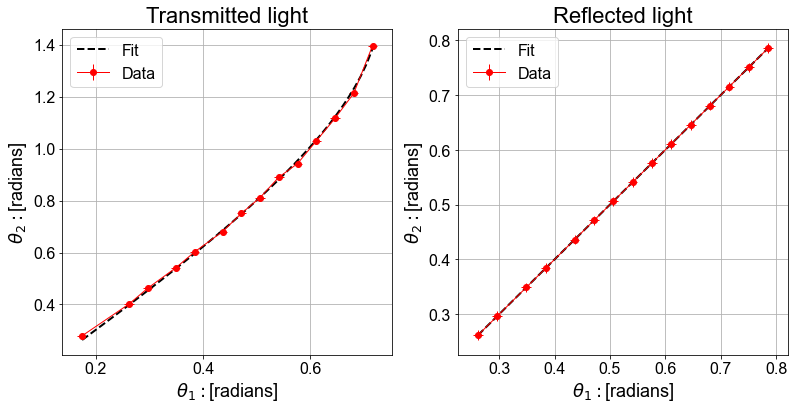

In [10]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title("Reflected light")
axs[0].set_title("Transmitted light")

def snell(theta, n):
    theta_ag = np.arcsin(n*np.sin(theta))
    return theta_ag

theta1T = np.zeros(len(ts_trans))
theta2T = np.zeros(len(ts_trans))

theta1R = np.zeros(len(ts_ref))
theta2R = np.zeros(len(ts_ref))

i = 0
for t1, t2 in ts_trans:
    theta1T[i] = t1
    theta2T[i] = t2+t1            # hvorfor t2 + t1 
    i = i + 1
    
i = 0
for t1, t2 in ts_ref:
    theta1R[i] = t1
    theta2R[i] = t1
    i = i + 1
    
theta1T1 = theta1T[0:len(theta1T)-3]
theta2T1 = theta2T[0:len(theta2T)-3]

print(theta1T1)
axs[0].errorbar(theta1T1, theta2T1, xerr=sigma_radian, yerr=sigma_radian, lw=1, label="Data", c='r', fmt='o-')
axs[1].errorbar(theta1R, theta2R, xerr=sigma_radian, yerr=sigma_radian, lw=1, label="Data", c='r', fmt='o-')


nT, pcovT = curve_fit(snell, theta1T1, theta2T1, absolute_sigma=True, p0=[1.4])
nR, pcovR = curve_fit(snell, theta1R, theta2R, absolute_sigma=True)

theta_T = np.linspace(min(theta1T1), max(theta1T1))
theta_R = np.linspace(min(theta1R), max(theta1R))

axs[0].plot(theta_T, snell(theta_T, nT), c='k', ls="--", label="Fit", lw=2)
axs[1].plot(theta_R, snell(theta_R, nR), c='k', ls="--", label="Fit", lw=2)

for ax in axs:
    ax.grid()
    ax.set_xlabel(r"$\theta_1: $[radians]")
    ax.set_ylabel(r"$\theta_2: $[radians]")
    ax.legend()


In [11]:
print(nR, nT)
ary = [1,2,3,4,5,6,7,8,9,10]
print(np.sqrt(np.diag(pcovT)))

uncer = 0.5 # DEGREES
sigma_radian = np.pi/180 * uncer
print(sigma_radian)

print(ary[:len(ary)-3])
print(Ts)

[1.] [1.49794579]
[0.21022842]
0.008726646259971648
[1, 2, 3, 4, 5, 6, 7]
[[ 1.00315545  0.002943  ]
 [ 0.99799614  0.002943  ]
 [ 1.06642288  0.002943  ]
 [ 1.12514899  0.002943  ]
 [ 0.02384677  0.002943  ]
 [ 1.04621401  0.002943  ]
 [ 1.09479608  0.002943  ]
 [ 1.0638005   0.002943  ]
 [ 1.06717843  0.002943  ]
 [ 1.03790306  0.002943  ]
 [ 1.1049593   0.002943  ]
 [ 1.02027867  0.002943  ]
 [ 1.04155484  0.002943  ]
 [ 0.63402329  0.002943  ]
 [ 0.00489958  0.002943  ]
 [-0.00264604  0.002943  ]
 [ 0.97154034  0.002943  ]]


<ipython-input-12-ac9d469e0184>:12: RuntimeWarning: invalid value encountered in arcsin
  theta_2 = np.arcsin(n_komb*np.sin(theta_1))
<ipython-input-12-ac9d469e0184>:7: RuntimeWarning: invalid value encountered in arcsin
  theta_2 = np.arcsin(n_komb*np.sin(theta_1))
<ipython-input-12-ac9d469e0184>:12: RuntimeWarning: invalid value encountered in arcsin
  theta_2 = np.arcsin(n_komb*np.sin(theta_1))
<ipython-input-12-ac9d469e0184>:7: RuntimeWarning: invalid value encountered in arcsin
  theta_2 = np.arcsin(n_komb*np.sin(theta_1))


Text(0, 0.5, '$R_p$')

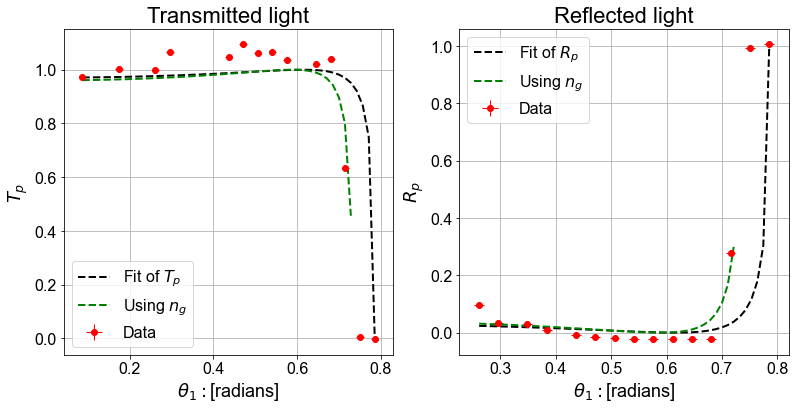

In [12]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title("Reflected light")
axs[0].set_title("Transmitted light")


def Rkoef(theta_1, n_komb): #Gælder kun for P polariseret lys
    theta_2 = np.arcsin(n_komb*np.sin(theta_1)) 
    R_p = (np.tan(theta_1-theta_2)**2)/(np.tan(theta_1+theta_2)**2)
    return R_p

def Tkoef(theta_1, n_komb): #Gælder kun for P polariseret lys
    theta_2 = np.arcsin(n_komb*np.sin(theta_1))
    T_p = (np.sin(2*theta_1)*np.sin(2*theta_2))/(np.sin(theta_1+theta_2)**2*np.cos(theta_1-theta_2)**2)
    return T_p

# Intensiteter
T_uc = []
R_uc = []
Tl = [] #Fjerner vinkler og punkter, hvor T,R ikke ligger mellem intervallet [0,1]
Rl = []

# Vinkler
theta_newT = []
theta_newR = []



for i, a in enumerate(Ts):
    if a[0] < 1.1 : #Fjerner dem her
        Tl.append(a[0])
        theta_newT.append(theta1T[i])
        T_uc.append(0.002943)

for i, a in enumerate(Rs):
    #if a[0] > 0 and a[0] < 1:
        Rl.append(a[0])
        theta_newR.append(theta1R[i])
        R_uc.append(0.002943)

theta_newT_new = np.delete(theta_newT, 3)
Tl_new = np.delete(Tl, 3)
T_uc = np.delete(T_uc, 3)

nTT, pcovnT = curve_fit(Tkoef, theta_newT_new, Tl_new, absolute_sigma=True, p0=[1.4])
nRR, pcovnR = curve_fit(Rkoef, theta_newR, Rl, absolute_sigma=True, p0=[1.4])

theta_Tp = np.linspace(min(theta_newT), max(theta_newT))
theta_Rp = np.linspace(min(theta_newR), max(theta_newR))

axs[0].errorbar(theta_newT_new, Tl_new, xerr=sigma_radian, yerr=T_uc, lw=1, label="Data", c='r', fmt='o')
axs[1].errorbar(theta_newR, Rl, xerr=sigma_radian, yerr=R_uc, lw=1,fmt='o', c='r', label="Data")
axs[0].plot(theta_Tp, Tkoef(theta_Tp, nTT), ls="--", c="k", lw=2, label=r"Fit of $T_p$")
axs[1].plot(theta_Rp, Rkoef(theta_Rp, nRR), ls="--", c="k", lw=2, label=r"Fit of $R_p$")

axs[0].plot(theta_Tp, Tkoef(theta_Tp, nT), ls="--", c="g", lw=2, label=r"Using $n_g$")
axs[1].plot(theta_Rp, Rkoef(theta_Rp, nT), ls="--", c="g", lw=2, label=r"Using $n_g$")


for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel(r"$\theta_1: $[radians]")
axs[0].set_ylabel(r"$T_p$")
axs[1].set_ylabel(r"$R_p$")



In [13]:
print(nTT, nRR)
#print(np.sqrt(np.diag(pcovnR)))
#print(np.sqrt(np.diag(pcovnT)))
print(nT, np.sqrt(np.diag(pcovT)))

[1.41421353] [1.4142135]
[1.49794579] [0.21022842]


# P-værdi og Chi^2 min værdi - for snells lov fit

In [14]:
yerr = np.zeros(len(theta1T1))
for i in range(len(yerr)):
    yerr[i] = 0.5*np.pi/180 #Fejlen på vores vinkler

v = len(theta1T1) - 1

chmin = np.sum(((theta2T1-snell(theta1T1, nT))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 


In [15]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

5.788897449072022  <  15.098659402942017  <  20.21110255092798
0.3


# P-værdi og Chi^2 min værdi - for T og R fit

In [16]:
yerr = np.zeros(len(Tl_new))
for i in range(len(yerr)):
    yerr[i] = 0.002943/np.sqrt(len(Tl_new)) #Fejlen på vores vinkler

v = len(Tl_new) - 1

chmin = np.sum(((Tl_new-Tkoef(theta_newT_new, nTT))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

In [17]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

5.788897449072022  <  1523356.6418907011  <  20.21110255092798
0.0


In [18]:
yerr = np.zeros(len(Rl))
for i in range(len(yerr)):
    yerr[i] = 0.002943/np.sqrt(len(Rl)) #Fejlen på vores vinkler

v = len(Rl) - 1

chmin = np.sum(((Rl-Rkoef(theta_newR, nRR))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

In [ ]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)